## Table of Contents

- [Basic Usage](#Basic-Usage)
  - [Displaying Grids of Molecules](#Displaying-Grids-of-Molecules)
  - [Design Units](#Design-Units)
  - [Advanced: Changing the Rendering Options](#Advanced:-Changing-the-Rendering-Options)
- [Polars Usage](#Polars-Usage)
  - [Substructure Highlighting](#Substructure-Highlighting)
- [Empty Molecules](#Empty-Molecules)
- [Design Unit DataFrames](#Design-Unit-DataFrames)
- [Aligned Molecule Depictions](#Aligned-Molecule-Depictions)
- [Fingerprint Similarity](#Fingerprint-Similarity)

In [1]:
import cnotebook
from cnotebook import molgrid
import polars as pl
import oepolars as oeplr
from pathlib import Path
from openeye import oechem, oedepict

EXAMPLES_DIRECTORY = Path("..")

# Basic Usage

**Rendering Basic Molecules**

Let's start with just viewing any object that derives from```oechem.OEMolBase``` (scroll further if you are looking for Polars examples).

<oechem.OEGraphMol; proxy of <Swig Object of type 'OEGraphMolWrapper *' at 0x1401411a0> >
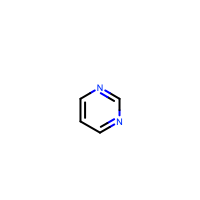

In [2]:
# Create a molecule
mol = oechem.OEGraphMol()
oechem.OESmilesToMol(mol, "n1cnccc1")

# Display the molecule
mol

How did this happen? When iPython encounters the bare ```mol``` statement, it tries to display the molecule in any way
it knows how. Usually this will just be an obscure string representation of a molecule that OpenEye provides: 
```oechem.OEGraphMol; proxy of ...```. However, CNotebook
has informed iPython on how to display molecules, so we see an image rather than that obscure string representation.


**Rendering OE2DMolDisplay Objects**

The same works with ```OE2DMolDisplay``` objects, which can include advanced rendering. For example, adding atom indices
to the depiction of the molecule that we just created:

<oedepict.OE2DMolDisplay; proxy of <Swig Object of type 'OEDepict::OE2DMolDisplay *' at 0x127b3b2d0> >
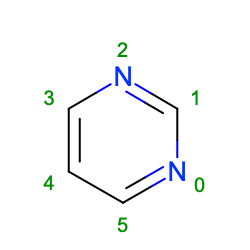

In [3]:
# Prepare the molecule for depiction
oedepict.OEPrepareDepiction(mol)

# Set the depiction options
opts = oedepict.OE2DMolDisplayOptions(250, 250, oedepict.OEScale_AutoScale)
opts.SetAtomPropertyFunctor(oedepict.OEDisplayAtomIdx())
opts.SetAtomPropLabelFont(oedepict.OEFont(oechem.OEDarkGreen))

# Create the display object
disp = oedepict.OE2DMolDisplay(mol, opts)

# Display the molecule
disp

Another popular example is to add SMARTS substructure highlighting.

<oedepict.OE2DMolDisplay; proxy of <Swig Object of type 'OEDepict::OE2DMolDisplay *' at 0x140fea6d0> >
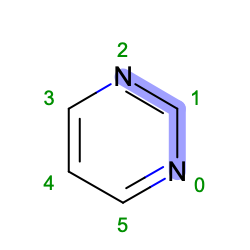

In [4]:
# Prepare the molecule for depiction
oedepict.OEPrepareDepiction(mol)

# Highlight the aromatic N-C-N in the molecule
subs = oechem.OESubSearch("ncn")
disp = oedepict.OE2DMolDisplay(mol, opts)

# Highlight all the matches in the molecule
for match in subs.Match(mol, True):
    oedepict.OEAddHighlighting(
        disp, 
        oechem.OEColor(oechem.OELightBlue),
        oedepict.OEHighlightStyle_Stick, 
        match
    )
    
# Display the molecule
disp

## Displaying Grids of Molecules

Sometimes you want to see several molecules in an interactive grid. Use `molgrid` for this:

```python
from cnotebook import molgrid

grid = molgrid(molecules)
grid.display()

# Later, retrieve selected molecules
selected = grid.get_selection()
```

MolGrid provides an interactive grid with:
* Pagination for large datasets
* Row selection
* Search/filtering
* Export functionality

In [5]:
# Create some sample molecules
mols = []
for i, smi in enumerate(["n1cnccc1", "c1ccccc1", "CCO", "C(=O)O", "CCCC"]):
    mol = oechem.OEGraphMol()
    oechem.OESmilesToMol(mol, smi)
    
    # We can title them too!
    mol.SetTitle(f'Molecule {i+1}')
    
    mols.append(mol)

# Render into an interactive grid
grid = molgrid(mols)
grid.display()

## Design Units

If you display a design unit, it will render the ligand or indicate that the design unit is apo.

<oechem.OEDesignUnit; proxy of <Swig Object of type 'OEBio::OEDesignUnit *' at 0x104c91ce0> >
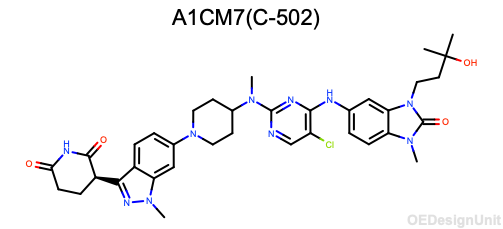

In [6]:
# Read an example design unit
du = oechem.OEDesignUnit()
oechem.OEReadDesignUnit(str(EXAMPLES_DIRECTORY / "assets" / "spruce_9Q03_ABC__DU__A1CM7_C-502.oedu"), du)

# Display it
du

<oechem.OEDesignUnit; proxy of <Swig Object of type 'OEBio::OEDesignUnit *' at 0x140feb8d0> >
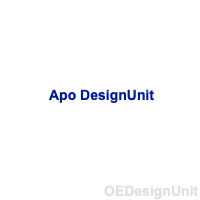

In [7]:
# Modify the design unit by deleting the ligand
apo_du = oechem.OEDesignUnit()
oechem.OESubsetDesignUnit(
    apo_du, 
    du, 
    oechem.OEDesignUnitComponents_MacroMolComponents
)
apo_du

## Advanced: Changing the Rendering Options

Basic rendering of molecules within Jupyter Notebooks is controlled by a global context. For simplicity, modifying the global context affects the display of molecules both in iPython (i.e., when you display molecules as above) and in Polars, which has not yet been introduced.

<oechem.OEGraphMol; proxy of <Swig Object of type 'OEGraphMolWrapper *' at 0x140fea910> >
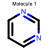

In [8]:
ctx = cnotebook.cnotebook_context.get()
ctx.height = 50
ctx.width = 50

# Display the original molecule again (but tiny)
mols[0]

<oechem.OEGraphMol; proxy of <Swig Object of type 'OEGraphMolWrapper *' at 0x140fea910> >
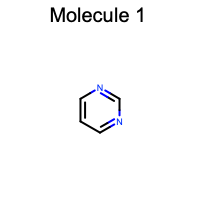

In [9]:
# Restore the settings
ctx.reset()

# Show the molecule again to prove the settings have been restored
mols[0]

By default, molecules scale with their size, meaning a really big molecule could take up the entire page. If you set a maximum height or width, you can prevent this (and the atom sizes / bond widths will scale with your molecule).

<oechem.OEGraphMol; proxy of <Swig Object of type 'OEGraphMolWrapper *' at 0x140febd20> >
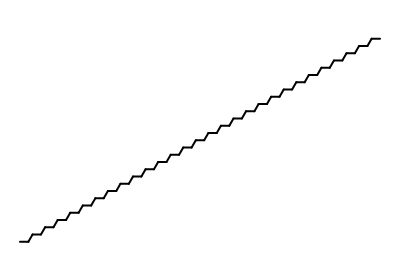

In [10]:
# Create a very long molecule - by default this much too large to render in a normal cell
long_mol = oechem.OEGraphMol()
oechem.OESmilesToMol(long_mol, "CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC")

# Change the max_width so that it fits comfortably in this notebook
ctx.max_width = 400

long_mol

In [11]:
# Reset our context so we don't affect the rest of the notebook
ctx.reset()

# Polars Usage

Similar to the simple examples above, the idea was to develop something that "just works" in a Notebook. Most of the
time you just don't want to have to think about it.

**Key Difference from Pandas**: Polars DataFrames are immutable. Operations that modify the DataFrame return a new
DataFrame rather than modifying the original in place. This is a fundamental difference from Pandas.

Let's create a sample DataFrame with no molecule objects:

In [12]:
df = pl.DataFrame({
    "Name": ["Benzene", "Pyridine", "Pyrimidine"],
    "Molecule": ["c1ccccc1", "c1cnccc1", "n1cnccc1"]
})

# Display it
df

Name,Molecule
Benzene,c1ccccc1
Pyridine,c1cnccc1
Pyrimidine,n1cnccc1


Now let's convert the SMILES to molecules. This is easy with a transparent extension added to Polars by the ```OEPolars``` package.

**Note**: Unlike Pandas, Polars returns a new DataFrame instead of modifying in place:

Name,Molecule
Benzene,
Pyridine,
Pyrimidine,

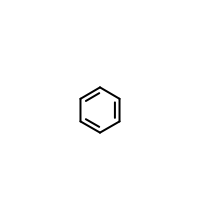
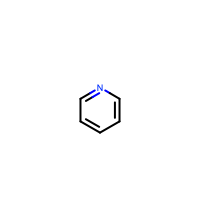
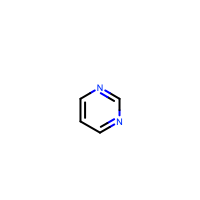

In [13]:
# Convert the Polars series to molecules
# This returns a new DataFrame (Polars is immutable)
df = df.chem.as_molecule("Molecule")

# Display it
df

Take a look at the **dtypes** (datatypes) for the columns. You'll see that the ```Molecule``` column has dtype ```molecule```, which means that we can perform chemistry-aware operations on the column. Pretty snazzy.

In [14]:
df.dtypes

[String, MoleculeType('molecule', Object)]

We can do things like calculate properties:

Name,Molecule,Heavy Atom Count
Benzene,,6
Pyridine,,6
Pyrimidine,,6

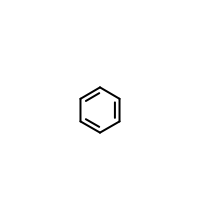
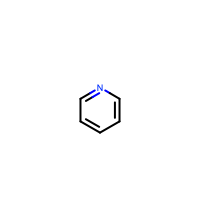
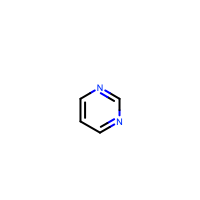

In [15]:
# Count the number of heavy atoms
df = df.with_columns(
    pl.col("Molecule").map_elements(
        lambda x: oechem.OECount(x, oechem.OEIsHeavy()),
        return_dtype=pl.Int64
    ).alias("Heavy Atom Count")
)

# Display it
df

## Substructure Highlighting

We can easily highlight substructures. With Polars, highlighting is applied at the DataFrame level to ensure metadata persists across column accesses:

Name,Molecule,Heavy Atom Count
Benzene,,6
Pyridine,,6
Pyrimidine,,6

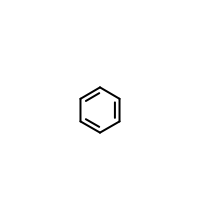
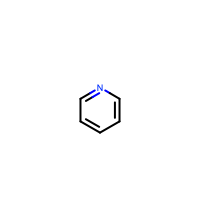
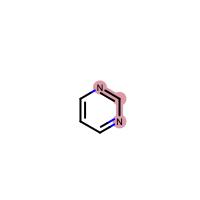

In [16]:
# Highlight aromatic N-C-N bonds
df.chem.highlight("Molecule", "ncn")

# Display it
df

Highlighting persists unless we remove it.

Name,Molecule,Heavy Atom Count
Benzene,,6
Pyridine,,6
Pyrimidine,,6

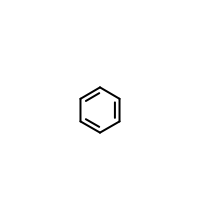
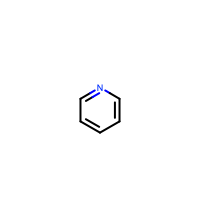
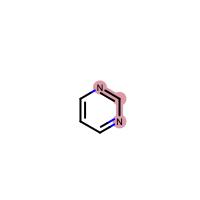

In [17]:
# Remove the highlighting (also removes any other display callbacks)
df.chem.reset_depictions()

# Display it
df

You can also highlight based on another column. This is useful if you have different SMARTS patterns that you'd like to highlight in each molecule.

Name,Molecule,Heavy Atom Count,SMARTS
Benzene,,6,"shape: (3,) Series: '' [str] [ ""cc"" ""cnc"" ""ncn"" ]"
Pyridine,,6,"shape: (3,) Series: '' [str] [ ""cc"" ""cnc"" ""ncn"" ]"
Pyrimidine,,6,"shape: (3,) Series: '' [str] [ ""cc"" ""cnc"" ""ncn"" ]"

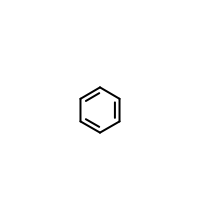
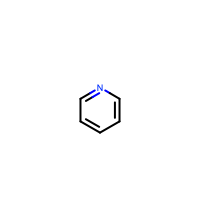
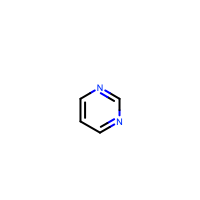

In [18]:
# Add a SMARTS column with patterns
df = df.with_columns(
    pl.lit(["cc", "cnc", "ncn"]).alias("SMARTS")
)
df.head()

Let's highlight those patterns. Note that ```highlight_using_column``` returns a new DataFrame with the highlighted column:

Name,Molecule,Heavy Atom Count,SMARTS,highlighted_substructures
Benzene,,6,"shape: (3,) Series: '' [str] [ ""cc"" ""cnc"" ""ncn"" ]",
Pyridine,,6,"shape: (3,) Series: '' [str] [ ""cc"" ""cnc"" ""ncn"" ]",
Pyrimidine,,6,"shape: (3,) Series: '' [str] [ ""cc"" ""cnc"" ""ncn"" ]",

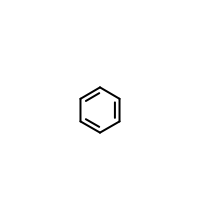
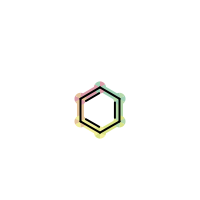
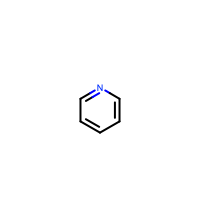
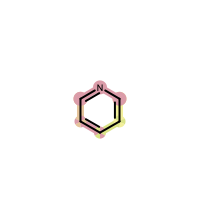
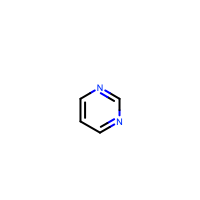
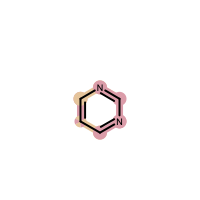

In [19]:
df = df.chem.highlight_using_column("Molecule", "SMARTS")
df

Note that ```highlight_using_column``` produces a different kind of output column where the elements are no longer molecules (they are in fact ```oedepict.OE2DMolDisplay``` objects). This is required to enable highlighting different substructures on a per-cell basis, versus highlighting the same substructure for an entire column. You can always check the datatypes: 

In [20]:
df.dtypes

[String,
 MoleculeType('molecule', Object),
 Int64,
 List(String),
 DisplayType('display', Object)]

# Empty Molecules

Empty molecules render an image in blue text. By default the size is 200x200 px.

<oechem.OEGraphMol; proxy of <Swig Object of type 'OEGraphMolWrapper *' at 0x14103f180> >
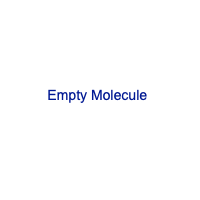

In [21]:
empty_mol = oechem.OEGraphMol()
empty_mol

# Design Unit DataFrames

You can also use design units in DataFrames in the same way as molecules.

DesignUnit,Ligand,PDB ID,Notes
,BCL6-760,9Q03,Spruce prepared PDB
,Apo,9Q03,Manually deleted ligand

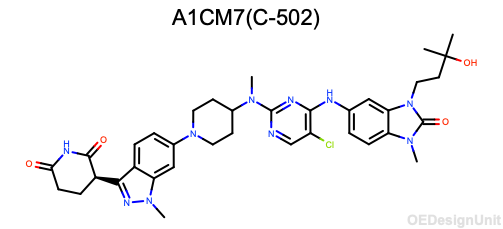
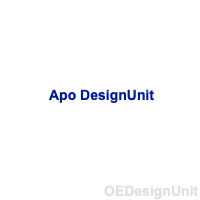

In [22]:
# Create a DataFrame and indicate that "DesignUnit" is an OEDesignUnit column
du_df = pl.DataFrame({
    "DesignUnit": [du, apo_du],
    "Ligand": ["BCL6-760", "Apo"],
    "PDB ID": ["9Q03", "9Q03"],
    "Notes": ["Spruce prepared PDB", "Manually deleted ligand"]
}).chem.as_design_unit("DesignUnit")

# Display it
du_df.head()

# Aligned Molecule Depictions

Sometimes you may have multiple molecules in a DataFrame that you may want to have aligned. There are two options:

1. Use ```align_depictions``` and you will regenerate the 2D coordinates of the molecules in a column based on a reference.
2. Use ```highlight``` with a reference, and it will both align and highlight the molecule.

Let's first take a look at our DataFrame. See how the bicyclic pyrimidine is not always in the same orientation?

Original,Title
,
,
,
,
,

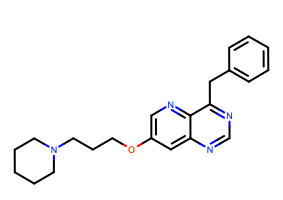
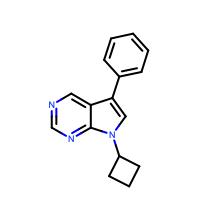
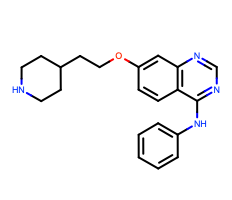
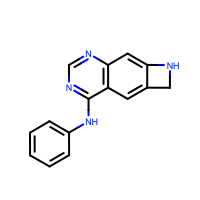
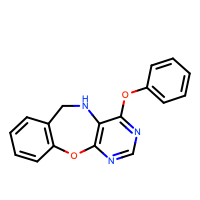

In [23]:
egfr_df = oeplr.read_smi(str(EXAMPLES_DIRECTORY / "assets" / "egfr.smi"))
egfr_df = egfr_df.rename({"Molecule": "Original"})
egfr_df.head()

Let's align based on the following template structure. This template was drawn in ChemDraw and saved as an MDL MOL file. We are going to read it in as an ```OEQMol```, which supports query features.

<oechem.OEQMol; proxy of <Swig Object of type 'OEQMolWrapper *' at 0x14103ec70> >
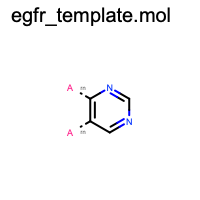

In [24]:
alignment_template = oechem.OEQMol()
with oechem.oemolistream(str(EXAMPLES_DIRECTORY / "assets" / "egfr_template.mol")) as ifs:
    oechem.OEReadMDLQueryFile(ifs, alignment_template)

# Show the template
alignment_template

Let's take a look at the ```align_depictions``` route, first. We're creating a new column called ```Aligned``` so that we can compare it to the original structure.

**Note**: With Polars, we need to use ```deepcopy``` to create a copy of the molecules, then align them:

Original,Title,Aligned
,,
,,
,,
,,
,,

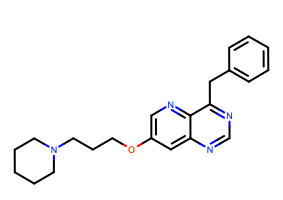
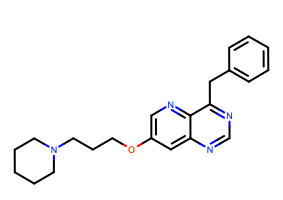
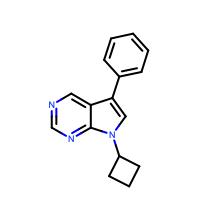
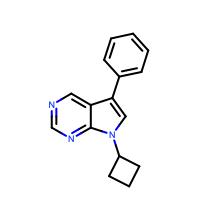
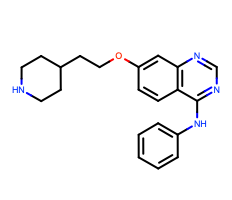
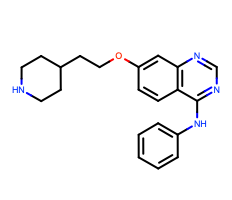
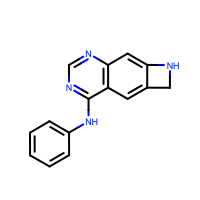
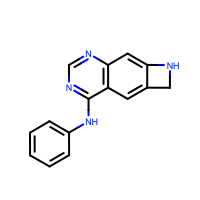
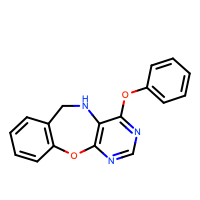
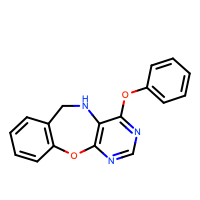

In [25]:
# Create a deep copy of the Original column for alignment
aligned_series = egfr_df.get_column("Original").chem.deepcopy()
aligned_series.chem.align_depictions(alignment_template)

# Add the aligned column to the DataFrame
egfr_df = egfr_df.with_columns(aligned_series.alias("Aligned"))
egfr_df.head()

Now lets look at the highlight route. We first align the molecules using ```align_depictions```, then highlight the template substructure at the DataFrame level. This allows you to align and highlight using different templates if you wish.

Original,Title,Aligned,Highlighted
,,,
,,,
,,,
,,,
,,,

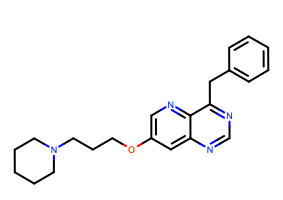
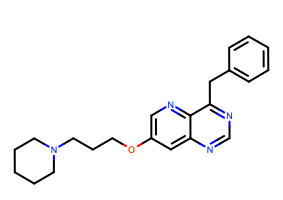
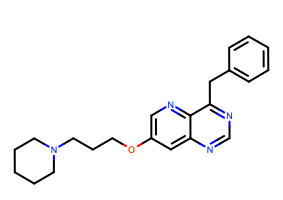
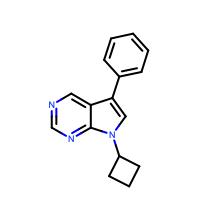
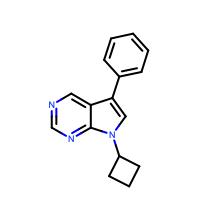
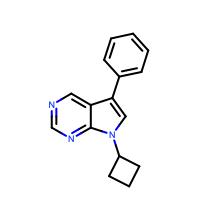
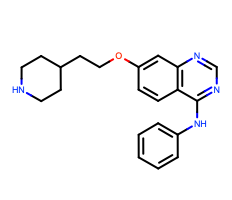
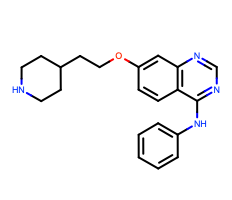
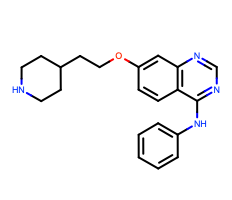
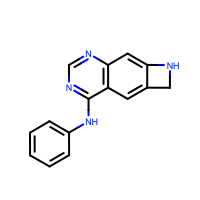
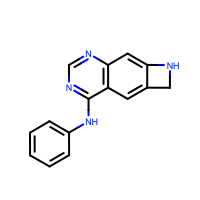
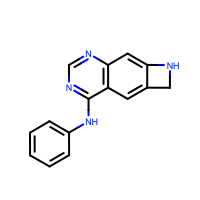
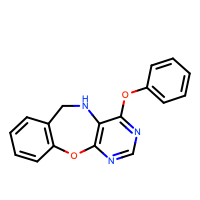
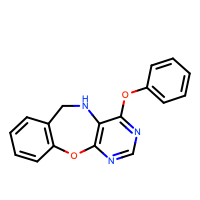
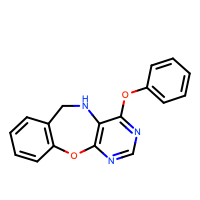

In [26]:
# Create a deep copy for highlighting and align to the template
highlighted_series = egfr_df.get_column("Original").chem.deepcopy()
highlighted_series.chem.align_depictions(alignment_template)

# Add the aligned column to the DataFrame
egfr_df = egfr_df.with_columns(highlighted_series.alias("Highlighted"))

# Highlight the template substructure
egfr_df.chem.highlight("Highlighted", alignment_template)
egfr_df.head()

It should be noted that a column can only be aligned to a single reference (at the moment). Subsequent calls to functions that set an alignment reference will override previous references.

# Fingerprint Similarity

You can color the fingerprint similarity between two structures. By default, this uses OpenEye Tree fingerprints of size 4096 with default atom and bond definitions. Note that the resulting columns are ```display``` columns, so they cannot be manipulated as molecules any longer.

Note that the second argument is optional. If this argument is omitted, then the first valid molecule in the DataFrame will be used as a reference.

<oechem.OEGraphMol; proxy of <Swig Object of type 'OEGraphMolWrapper *' at 0x141078cc0> >
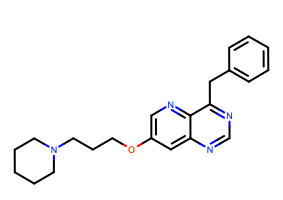

In [27]:
# Read a reference molecule
refmol = oechem.OEGraphMol()

with oechem.oemolistream(str(EXAMPLES_DIRECTORY / "assets" / "egfr.smi")) as ifs:
    oechem.OEReadMolecule(ifs, refmol)
    refmol.SetTitle('')

# Display it
refmol

Molecule,Title,fingerprint_tanimoto,reference_similarity,target_similarity
,,1.0,,
,,0.15948276221752167,,
,,0.3316831588745117,,
,,0.25123152136802673,,
,,0.2238806039094925,,

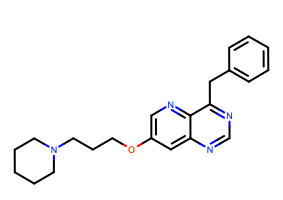
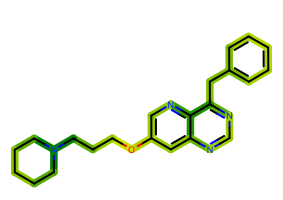
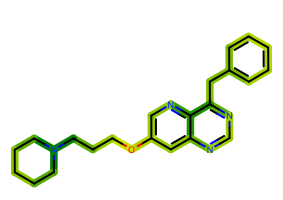
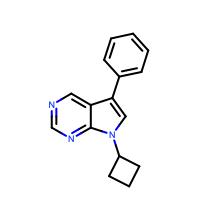
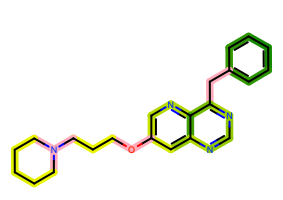
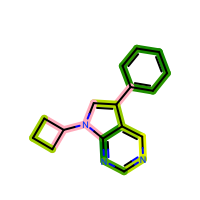
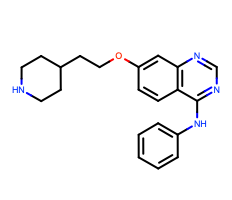
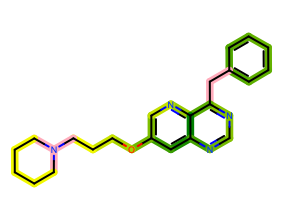
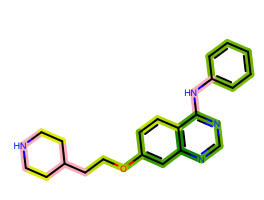
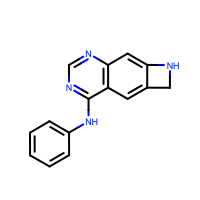
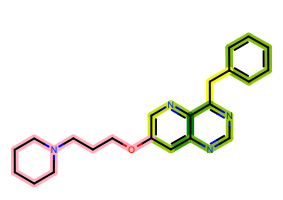
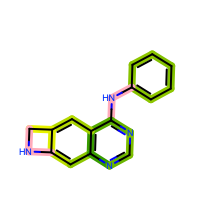
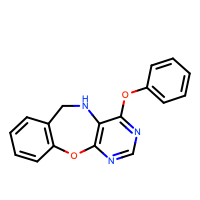
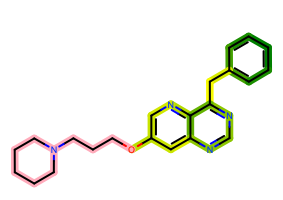
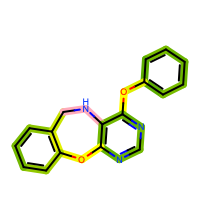

In [28]:
# Re-read the EGFR DataFrame
egfr_df = oeplr.read_smi(str(EXAMPLES_DIRECTORY / "assets" / "egfr.smi"))

# Calculate fingerprint similarity (returns a new DataFrame)
egfr_df = egfr_df.chem.fingerprint_similarity("Molecule", refmol)
egfr_df.head()